# Part 2: Pneumonia Prediction

In [10]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from os import listdir
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score

### Q2 CNN Classifier (3 Pts)

Data Preprocessing using histogram equalization and gaussian blurring

In [ ]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize the image
    img = cv2.resize(img, (1000, 1000))

    # Histogram Equalization
    img = cv2.equalizeHist(img)

    # Gaussian Blur (5x5 kernel)
    final_img = cv2.GaussianBlur(img, (5, 5), 0)
    
    return final_img

Comparison between original image and processed image

Text(0.5, 1.0, 'Processed Image')

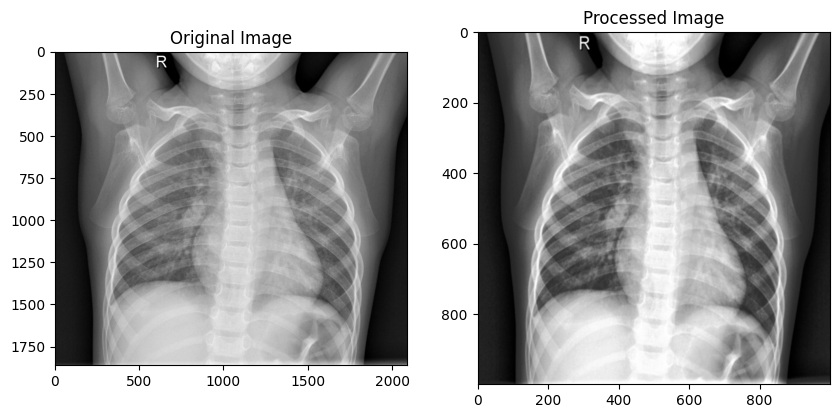

In [22]:
img_normal1 = np.asarray(Image.open('data_part2/train/NORMAL/IM-0115-0001.jpeg'))

img_processed = preprocess_image('data_part2/train/NORMAL/IM-0115-0001.jpeg')

fig, axes = plt.subplots(1, 2, figsize=(10, 7))

axes[0].imshow(img_normal1, cmap='gray')
axes[0].set_title('Original Image')

axes[1].imshow(img_processed, cmap='gray')
axes[1].set_title('Processed Image')


In [ ]:
# Performing preprocessing on all images for training set, validation set, and test set

# Need to do this for the following pairs {train, val, test} x {NORMAL, PNEUMONIA} (already done, see data_part2_processed folder)
folder_dir = 'data_part2/train/NORMAL/'
processed_dir = 'data_part2_processed/train/NORMAL/'

for images in os.listdir(folder_dir):
    processed_image = preprocess_image(os.path.join(folder_dir, images))

    cv2.imwrite(os.path.join(processed_dir, images), processed_image)

#### Loading the data

In [5]:
transform = transforms.ToTensor()

trainset = ImageFolder(root="data_part2_processed/train/", transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

validationset = ImageFolder(root="data_part2_processed/val/", transform=transform)
validationloader = DataLoader(validationset, batch_size=32, shuffle=True)

testset = ImageFolder(root="data_part2_processed/test/", transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=True)

In [10]:
images, labels = next(iter(trainloader))
print(images.shape)  # should be [32, 1, 1000, 1000]
print(labels.shape)  # should be [32]

torch.Size([32, 3, 1000, 1000])
torch.Size([32])


#### CNN and training

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return torch.sigmoid(x)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

In [8]:
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()

    for images, labels in tqdm(trainloader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float().unsqueeze(1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in validationloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(validationloader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

100%|██████████| 163/163 [01:53<00:00,  1.43it/s]


Epoch [1/5], Training Loss: 0.5446, Validation Loss: 0.6733


100%|██████████| 163/163 [01:52<00:00,  1.45it/s]


Epoch [2/5], Training Loss: 0.4909, Validation Loss: 0.6874


100%|██████████| 163/163 [01:53<00:00,  1.44it/s]


Epoch [3/5], Training Loss: 0.4386, Validation Loss: 0.7531


100%|██████████| 163/163 [01:50<00:00,  1.47it/s]


Epoch [4/5], Training Loss: 0.3982, Validation Loss: 0.7964


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


Epoch [5/5], Training Loss: 0.3547, Validation Loss: 0.6818


In [11]:
# Evaluation on test set
model.eval()
test_loss = 0.0
correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(testloader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels.float().unsqueeze(1))
        test_loss += loss.item()

        # Accuracy calculation
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels.unsqueeze(1)).sum().item()
        total += labels.size(0)

        # AUROC and AUPRC calculation
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

avg_test_loss = test_loss / len(testloader)
accuracy = correct / total
auroc = roc_auc_score(all_labels, all_preds)
auprc = average_precision_score(all_labels, all_preds)

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy*100:.2f}%")
print(f"Test AUROC: {auroc:.4f}, Test AUPRC: {auprc:.4f}")

100%|██████████| 20/20 [00:12<00:00,  1.66it/s]

Test Loss: 0.6851, Test Accuracy: 69.23%
Test AUROC: 0.7684, Test AUPRC: 0.7991


In [13]:
# Saving the model weights
torch.save(model.state_dict(), 'part2_cnn_weights/CNN_weights.pth')